# Full pipeline by Senor Army Junior Paopeaw Faith Jeanz (We are just a chill guy)

# Import Lib and file

In [ ]:
%pip install requirement.txt

In [1]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)
Setup complete ✅ (16 CPUs, 15.5 GB RAM, 113.4/1006.9 GB disk)


# FOR TA's LOCAL TEST

In [ ]:
chess_model = "./weights/yolo8-20epoch.pt"
hand_model = "./weights/Hand-yolo.pt"

#IF no dataset

#set your dataset root
#should look something like dataset_root = './Chess Detection Competition' 

#path to a video
# /home/jaf/ChessDetection/Chess Detection Competition/test_videos/2_Move_rotate_student.mp4
dataset_root = './Chess Detection Competition'


print(chess_model)

./weights/yolo8-20epoch.pt


In [3]:
import matplotlib.pyplot as plt
import math
import operator
import sys
import pandas as pd
from collections import defaultdict

import numpy as np
import cv2

import scipy.spatial as spatial
import scipy.cluster as clstr

import heapq
import math
from sklearn.cluster import KMeans

import os
import collections
import chess
import chess.pgn


# Final PipeLine

## Pre Process Func

In [4]:
def getGreenMask(rgb_image):
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)  # Convert to HSV color space

    # Define the green color range in HSV
    lower_green = np.array([40, 20, 30])  # Lower bound of green
    upper_green = np.array([100, 255,200])  # Upper bound of green

    # Create a mask for green color
    green_mask = cv2.inRange(hsv, lower_green, upper_green)

    kernel = np.ones((20,20), np.uint8)
    green_mask_= cv2.morphologyEx(green_mask,cv2.MORPH_OPEN, kernel,10)
    green_mask= cv2.erode(green_mask, kernel,3)

    # Apply the mask to the original image
    green_detected = cv2.bitwise_and(rgb_image, rgb_image, mask=green_mask)

    return green_mask, green_detected


def GetCorner(binary_img):
    x_indices, y_indices = np.where(binary_img == 255)

    # # Get the min and max positions for x and y
    x_min, x_max = x_indices.min(), x_indices.max()
    y_min, y_max = y_indices.min(), y_indices.max()

    # print(f"Min X: {x_min}, Max X: {x_max}")
    # print(f"Min Y: {y_min}, Max Y: {y_max}")
    return x_min,y_min,x_max,y_max

def CropAndPadding(rgb_image, binary_image, padd,x_min,y_min,x_max,y_max):
    # plt.imshow(binary_image)
    # plt.show()
    st_crop = binary_image[x_min:x_max,y_min:y_max]
    # plt.imshow(st_crop)
    # plt.show()
    # print(x_min,y_min,x_max,y_max)

    w,h = rgb_image.shape[:2];
    x_min_padd = max(0, x_min-padd)
    x_max_padd = min(w, x_max+padd)
    y_min_padd = max(0, y_min-padd)
    y_max_padd = min(h, y_max+padd)

    # rgb_crop = rgb[x_min:x_max,y_min:y_max,:]
    rgb_crop = rgb_image[x_min_padd:x_max_padd,y_min_padd:y_max_padd,:]
    return rgb_crop

def rotateImageBasedOnBlackPiece(rgb_image):
    hsv = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2HSV)  # Convert to HSV color space

    # Define the green color range in HSV
    lower_black = np.array([0, 0, 0])  # Lower bound of green
    upper_black = np.array([180, 50,100])  # Upper bound of green

    # Create a mask for green color
    black_mask = cv2.inRange(hsv, lower_black, upper_black)

    # kernel for cleaning mask
    close_kernel = np.ones((10,10), np.uint8)
    ero_kernel = np.ones((8,8), np.uint8)

    # cleaning mask
    black_mask = cv2.morphologyEx(black_mask,cv2.MORPH_CLOSE, close_kernel)
    black_mask= cv2.erode(black_mask, close_kernel,20)


    # Output
    output = cv2.connectedComponentsWithStats(black_mask, 8, cv2.CV_32S)

    num_count = output[0]-1
    stat = output[2]
    centroids = output[3]

    counts = [0,0,0,0] # down, right, up, left
    image_height = rgb_image.shape[0]
    image_width = rgb_image.shape[1]
    for i in range(len(centroids)):
        center_x, center_y = int(centroids[i][0]), int(centroids[i][1])
        if(center_y >= image_height/2):
            counts[0] += 1;
        else:
            counts[2] += 1;
        if(center_x >= image_width/2):
            counts[3] += 1;
        else:
            counts[1] += 1;

    m = np.argmax(counts)
    # print(f'rotation:{m}')
    return m
    # rotate_image = np.rot90(rgb_image, m) ## counter clock wise
    # # return green_mask, green_detected
    # return rotate_image;
class HandDetector:
    def __init__(self, model_path):
        self.model = YOLO(model_path)

    def IsFoundPerson(self, results):
        for det in results[0].boxes:
            cls = int(det.cls)
            if cls == 0:
                return True
        return False

    def predict(self, image):
        results = self.model.predict(image,verbose=False)
        return self.IsFoundPerson(results)  # Use self to call the instance method


In [5]:
def show_image(img, title="Image"):
    """Display an image using matplotlib."""
    if len(img.shape) == 2:  # Grayscale image
        plt.imshow(img, cmap='gray')
    else:  # Color image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.title(title)
    # plt.axis('off')
    plt.show()


def canny(img):
    # Compute the median intensity of the already blurred image
    # Use Otsu's method to determine a global threshold
    otsu_threshold, _ = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Compute lower and upper thresholds for Canny
    lower_threshold = max(0, int(0.5 * otsu_threshold))
    upper_threshold = min(255, int(otsu_threshold))

    # Apply Canny edge detection
    edges = cv2.Canny(img, lower_threshold, upper_threshold)
    return edges



def hough_lines(img):
    rho, theta, thresh = 2, np.pi / 180, 600
    return cv2.HoughLines(img, rho, theta, thresh)


def sort_lines(lines):
    """
    Sorts lines by horizontal and vertical
    """
    h = []
    v = []
    for i in range(lines.shape[0]):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v.append([rho, theta])
        else:
            h.append([rho, theta])
    return h, v


def calculate_intersections(h, v):
    """
    Finds the intersection of two lines given in Hesse normal form.
    See https://stackoverflow.com/a/383527/5087436
    """
    points = []
    for rho1, theta1 in h:
        for rho2, theta2 in v:
            A = np.array([
                [np.cos(theta1), np.sin(theta1)],
                [np.cos(theta2), np.sin(theta2)]
            ])
            b = np.array([[rho1], [rho2]])
            point = np.linalg.solve(A, b)
            point = int(np.round(point[0])), int(np.round(point[1]))
            points.append(point)
    return np.array(points)


def cluster_intersections(points, max_dist=40):
    # I want to change this to kmeans
    Y = spatial.distance.pdist(points)
    Z = clstr.hierarchy.single(Y)
    T = clstr.hierarchy.fcluster(Z, max_dist, 'distance')
    clusters = defaultdict(list)
    for i in range(len(T)):
        clusters[T[i]].append(points[i])
    clusters = clusters.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:, 0]), np.mean(np.array(arr)[:, 1])), clusters)

    result = []
    for point in clusters:
        result.append([point[0], point[1]])
    sorted_result = sorted(result, key=lambda pair: (pair[0], pair[1]))
    outlier_removal_result = filter_chessboard_coordinates(sorted_result)
    return outlier_removal_result


def find_chessboard_corners(points):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0] + pt[1] for pt in points]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0] + pt[1] for pt in points]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0] - pt[1] for pt in points]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0] - pt[1] for pt in points]), key=operator.itemgetter(1))
    return [points[top_left], points[top_right], points[bottom_left], points[bottom_right]]


def distance_between(p1, p2):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def warp_image(img, edges):
    """
    Code from https://medium.com/@neshpatel/solving-sudoku-part-ii-9a7019d196a2
    """
    top_left, top_right, bottom_left, bottom_right = edges[0], edges[1], edges[2], edges[3]

    # Explicitly set the data type to float32 or 'getPerspectiveTransform' will throw an error
    warp_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    warp_dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(warp_src, warp_dst)
    # print(f'warped transform matrix: {m}')

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))


def cut_chessboard(img, output_path, output_prefix=""):
    side_len = int(img.shape[0] / 8)
    for i in range(8):
        for j in range(8):
            tile = img[i * side_len: (i + 1) * side_len, j * side_len: (j + 1) * side_len]
            cv2.imwrite(output_path + output_prefix + "-" + str(j + i * 8) + ".jpg", tile)


def resize_image(img):
    """
    Resizes image to a maximum width of 800px
    """
    return cv2.resize(img, (800, 800))
    # else:
    #     return img
def save_clustered_to_csv(clustered, filename="clustered_intersections.csv"):
    # Convert clustered data into a DataFrame
    df = pd.DataFrame(clustered, columns=["x", "y"])
    # Save DataFrame to a CSV file
    df.to_csv(filename, index=False)
    print(f"Clustered intersections saved to {filename}")


def render_lines(img, lines, color):
    for rho, theta in lines:
        a = math.cos(theta)
        b = math.sin(theta)
        x0, y0 = a * rho, b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        cv2.line(img, pt1, pt2, color, 1, cv2.LINE_AA)


def render_intersections(img, points, color, size):
    for point in points:
        cv2.circle(img, (int(point[0]), int(point[1])), 2, color, size)

def find_3_closest(clustered):
    # Find the reference point
    ref_point = min(clustered, key=lambda pair: (pair[0], -pair[1]))

    # Helper function to calculate Euclidean distance
    def distance(point):
        return math.sqrt((point[0] - ref_point[0])**2 + (point[1] - ref_point[1])**2)

    # Filter out the reference point and find the 3 closest points
    filtered_points = [point for point in clustered if point != ref_point]
    closest_points = heapq.nsmallest(3, filtered_points, key=distance)

    return ref_point, closest_points
def filter_chessboard_coordinates(coordinates):
    """
    Filters the given chessboard intersection points to ensure there are exactly 81 points.

    Args:
        coordinates (list of list): A list of [x, y] coordinates.

    Returns:
        list of list: A filtered list of 81 coordinates as [x, y].
    """
    filtered_coordinates = coordinates

    if len(coordinates) > 81:
      coordinates = np.array(coordinates)  # Convert input coordinates to a numpy array

      # Perform K-means clustering to group points into 81 clusters
      kmeans = KMeans(n_clusters=81, random_state=42)
      kmeans.fit(coordinates)
      cluster_centers = kmeans.cluster_centers_

      # Convert the cluster centers to rounded coordinates and return as a list of lists
      filtered_coordinates = np.round(cluster_centers, decimals=2).tolist()

    return filtered_coordinates



In [6]:
def process_chessboard(src, debug=False):
    # src = cv2.imread(src_path)

    # if src is None:
    #     sys.exit("There is no file with this path!")

    # src = resize_image(src)
    # src_copy = src.copy()

    # # Convert to grayscale
    # process = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    src = src
    src_copy = src.copy()
    process = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

    if debug:
        show_image(src_copy, title=f'src img{src_copy.shape}')
        show_image(process, title=f'gray process imgae{process.shape}')
        # cv2.imwrite('grayscale.png', process)

    # Blur to remove disturbing things
    # process = cv2.blur(process, (4, 4))
    #process = cv2.medianBlur(process, 5)
    process = cv2.GaussianBlur(process, (5, 5), 0) #GaussianBlur give a better result


    if debug:
        show_image(process, title=f'blur process imgae{process.shape}')

        # cv2.imwrite('blur.png', process)

    # Use Canny Edge Detector
    process = canny(process)

    if debug:
        show_image(process, title=f'canny process imgae{process.shape}')
        # cv2.imwrite('canny.png', process)

    # Dilate image (thicker lines)
    process = cv2.dilate(process, np.ones((3, 3), dtype=np.uint8))

    if debug:
        show_image(process, title=f'dialate process imgae{process.shape}')
        # cv2.imwrite('dilate.png', process)

    # Use Hough transform to detect lines
    lines = hough_lines(process)

    # Sort lines by horizontal and vertical
    h, v = sort_lines(lines)

    if debug:
        render_lines(src_copy, h, (0, 255, 0))
        render_lines(src_copy, v, (0, 0, 255))
        show_image(src_copy, title="Sorted Lines")
        # cv2.imwrite('sorted-lines.png', src_copy)

    if len(h) < 9 or len(v) < 9:
        print("There are not enough horizontal and vertical lines in this image. Try it anyway!")

    # Calculate intersections of the horizontal and vertical lines
    intersections = calculate_intersections(h, v)

    if debug:
        render_intersections(src_copy, intersections, (255, 0, 0), 1)
        show_image(src_copy, title="Intersections")
        # cv2.imwrite('intersections.png', src_copy)

    # Cluster intersection since there are many
    clustered = cluster_intersections(intersections)
    filtered_clustered = filter_chessboard_coordinates(clustered)

    if debug:
        src_copy = src.copy()
        render_intersections(src_copy, clustered, (255, 0, 0), 5)
        show_image(src_copy, title="Clustered Intersections")
        print(clustered)
        save_clustered_to_csv(clustered)
        result = min(clustered, key=lambda pair: (pair[0], -pair[1]))
        if result:
          print(f'corner: {result}')
          # print(find_3_closest(clustered))
          # results2 = is_black_or_white_with_visualization(src_path, find_3_closest(clustered), 10, 128)
          # print(results2)


        # cv2.imwrite('clustered-intersections.png', src_copy)

    if len(clustered) != 81:
        print("Something is wrong. There are " + str(len(intersections)) + " instead of 81 intersections.")

    # Find outer corners of sas chessboard
    corners = find_chessboard_corners(clustered)

    if debug:
        src_copy = src.copy()
        render_intersections(src_copy, corners, (255, 0, 0), 5)
        show_image(src_copy, title="Corners")
        # cv2.imwrite('corners.png', src_copy)

    # Warp and crop image
    # dst = warp_image(src, corners)
    # dst = resize_image(dst)
    return corners,filtered_clustered

    if debug:
        show_image(dst, title=f'warped process imgae{dst.shape}')
        # cv2.imwrite('warped.png', dst)

    # Cut chessboard into 64 tiles
    # cut_chessboard(dst, output_path, output_prefix)



In [7]:
from ultralytics import YOLO
class YOLOPredictor:
    def __init__(self, model_path):
        """
        Initialize the YOLO model.

        :param model_path: Path to the trained YOLO model.
        """
        self.model = YOLO(model_path)
        
        self.class_names = [
            "black-bishop",
            "black-king",
            "black-knight",
            "black-pawn",
            "black-queen",
            "black-rook",
            "white-bishop",
            "white-king",
            "white-knight",
            "white-pawn",
            "white-queen",
            "white-rook",
        ]
        
    def predict(self, image_path):
        """
        Predict bounding boxes for the given image and return in the specified format.

        :param image_path: Path to the image for prediction.
        :return: List of bounding boxes in the format [class_number, class_name, x, y, width, height, conf]
        """
        results = self.model.predict(image_path)
        bbox_list = []

        for result in results:
            # Get image dimensions
            w, h, _ = result.orig_img.shape

            # Iterate through detections in each result
            for det in result.boxes:
                # Get normalized xywh (YOLO format) and class confidence
                x_center, y_center, width, height = det.xywhn[0]
                conf = det.conf.item()  # Convert the tensor to a float value
                cls = int(det.cls)  # Class number

                # Denormalize to pixel values
                x_center_pixel = int(x_center * w)
                y_center_pixel = int(y_center * h)
                width_pixel = int(width * w)
                height_pixel = int(height * h)

                # Calculate starting point (top-left corner) of the bounding box
                x = int(x_center_pixel - width_pixel / 2)
                y = int(y_center_pixel - height_pixel / 2)

                # Get class name from class_names
                class_name = self.class_names[cls]

                # Append to the list in the format [class_number, class_name, x, y, width, height, conf]
                bbox_list.append([cls, class_name, x, y, width_pixel, height_pixel, conf])

        return bbox_list


def objectDetection(img_path,model_path):

  predictor = YOLOPredictor(model_path)
  predictor.conf = 0.50
  bbox_list = predictor.predict(img_path)
  return bbox_list


In [8]:
def printBoundingBox(bbox_list, count):
    print(f'==========================={count}======================================')

    # result = []
    # for classNumber, className, x, y, w, h, conf in bbox_list:
    #     result.append([className,classNumber, x, y, w, h, conf])

    # # Print the entire list in the desired format
    # print(result)
    for classNumber, className, x, y, w, h, conf in bbox_list:
      print(f'{className} {conf}')
    # return result


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_bounding_boxes(warped_resize_rotated_image, boundingBox):
    """
    Plots bounding boxes on a given image.

    Parameters:
    - warped_resize_rotated_image: np.ndarray
        The image on which to draw the bounding boxes.
    - boundingBox: list of lists
        Each inner list contains [cls, class_name, x, y, width_pixel, height_pixel, conf].
    """
    # Plot the image
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(warped_resize_rotated_image)

    # Plot bounding boxes
    for bbox in boundingBox:
        _, class_name, x, y, width, height, conf = bbox

        # Create a rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

        # Add label text
        label = f"{class_name} ({conf:.2f})"
        ax.text(
            x, y - 5, label,
            color='white', fontsize=12,
            bbox=dict(facecolor='red', alpha=0.5, edgecolor='none')
        )

    # Hide axis for better visualization
    plt.axis('off')
    plt.show()

## Post process

In [10]:
PIECE_MAP = {
    0: "b", 1: "k", 2: "n", 3: "p", 4: "q", 5: "r",
    6: "B", 7: "K", 8: "N", 9: "P", 10: "Q", 11: "R",
}
def detection_to_chess_coordinates(objects):
    # Constants
    CELL_SIZE = 100
    GRID_SIZE = 8  # 8x8 chessboard

    result = []

    for obj in objects:
        class_no,class_name ,  x, y, w, h, confidence = obj
        # Calculate the top of the chess piece
        bottom_y = y + (h * 0.75)
        right_x = x + (w * 0.5)

        # Calculate the cell (i, j)
        i = min(max(int(bottom_y // CELL_SIZE), 0), GRID_SIZE - 1)  # Ensure i is within [0, 7]
        j = min(max(int(right_x // CELL_SIZE), 0), GRID_SIZE - 1)      # Ensure j is within [0, 7]

        # Append the result
        result.append([class_no, i, j])

    return result

def create_board(chess_coordinates):
    board = chess.Board()
    board.clear()  # Clear the default starting position

    # Place pieces based on the coordinates
    for class_no, i, j in chess_coordinates:
        piece = chess.Piece.from_symbol(PIECE_MAP[class_no])
        square = chess.square(7 - j, i)  # Convert (i, j) to a chess square
        board.set_piece_at(square, piece)

    return board


def boards_to_pgn_move(prev_board, next_board, override_turn = False, override_rule = False):
    # Detect the move by comparing squares
    move = None

    start_list = collections.deque()
    destination_list = []
    move_count = 0
    for square in chess.SQUARES:
        prev_piece = prev_board.piece_at(square)
        next_piece = next_board.piece_at(square)
        if prev_piece != next_piece:
            # print(prev_piece, next_piece)
            move_count += 1
            if prev_piece and next_piece == None:  # Piece moved from this square
                if(prev_piece.piece_type == chess.KING):
                    start_list.appendleft((prev_piece,square))
                else:
                    start_list.append((prev_piece,square))
            elif next_piece:  # Piece moved to this square
                if(prev_piece == None): # Move
                    destination_list.append((next_piece,square,False))
                elif(prev_piece.color != next_piece.color): # Capture
                    destination_list.append((next_piece,square,True))

    is_move = False
    out = ""
    misc = []
    for piece_from, pos_from in start_list:
        for piece_to, pos_to,is_capture in destination_list:
            if(piece_from == piece_to):
                move = chess.Move(pos_from, pos_to)
                misc = [piece_from.color]
                # print(prev_board.legal_moves)
                print(piece_from, pos_from, pos_to)
                if(override_turn):
                    prev_board.turn = piece_from.color

                # Check for castling
                if prev_board.is_kingside_castling(move):
                    is_move = True
                    out = "O-O"
                    return is_move, out, misc
                elif prev_board.is_queenside_castling(move):
                    is_move = True
                    out = "O-O-O"
                    return is_move, out, misc

                # if(prev_board.is_pseudo_legal(move)):
                if(prev_board.is_legal(move) or override_rule):
                    game = chess.pgn.Game()
                    game.setup(prev_board)
                    game.add_main_variation(move)
                    is_move = True
                    out = str(game.variation(0)).split()[1]
                    return is_move, out, misc

    return is_move, out, misc

def frames_to_pgn_movelist(frames):
    boards = []

    for frame in frames:
        chess_coordinates = detection_to_chess_coordinates(frame)
        boards.append(create_board(chess_coordinates))

    pgn_movelist = ""

    step = 0
    game_turn = 1
    last_valid_board = None
    for board in boards:

        if step == 0:
            last_valid_board = board
            step = 1
        else:
            is_move, pgn_move, misc = boards_to_pgn_move(last_valid_board, board, override_turn=True,override_rule=True)
            last_valid_board = board


            if(is_move):
                display(chess.svg.board(board, size=200))
                if(step % 2 == 0):
                    pgn_movelist += pgn_move + " "
                else:
                    if(step == 1 and misc == [chess.BLACK]):
                        pgn_movelist += str(game_turn) + "... " + pgn_move + " "
                        step += 1
                    else:
                        pgn_movelist += str(game_turn) + ". " + pgn_move + " "
                    game_turn += 1
                step += 1

    return pgn_movelist

def post_process_pipeline(clip_name, frames):
    # clip_name = name of clip (string)
    # frames = list of frame
    # frame = list of objects (chess piece that is detected in the frame)
    # object = [class_number, x, y, width, height]
    # x = middle of object horizontal position
    # y = middle of object vertical position
    # assumptions: image size = 800 px --> x 0-100 = chess column 1
        # Class number definitions:
        #     "0: white-queen",
        #     "1: white-pawn",
        #     "2: black-rook",
        #     "3: black-bishop",
        #     "4: black-knight",
        #     "5: black-queen",
        #     "6: black-pawn",
        #     "7: black-king",
        #     "8: white-rook",
        #     "9: white-bishop",
        #     "10: white-knight",
        #     "11: white-king",

    pgn_movelist = frames_to_pgn_movelist(frames)
    output = [clip_name, pgn_movelist]
    return output
def export_csv_result(list_of_output, output_path="submission.csv"):
    # output = output from post_process_pipeline for each clip

    # fix bonus clip name
    if(list_of_output[-1][0] == "Bonus Long Video Label.mp4"):
        list_of_output[-1][0] = "(Bonus)Long_video_student.mp4"
    
    df = pd.DataFrame(list_of_output, columns=["row_id", "output"])
    # df.to_csv("./kaggle/working/submission.csv", index = False, header = True)
    df.to_csv(output_path, index = False, header = True)

# Final Function

In [11]:
def process_video(video_path,frame_per_second,chess_model_path,hand_model_path,Debug):
    """
    Processes a video to extract and analyze frames at specific intervals.

    Parameters:
    - video_path (str): Path to the video file.
    - frame_per_second (int): Number of frames to skip before processing the next one.
    """
    video = cv2.VideoCapture(video_path)
    success = True
    count = 0
    prev_gray = None
    x_min, y_min, x_max, y_max = None, None, None, None
    rotation_default = None
    handDetector = HandDetector(hand_model_path)
    bbox_of_each_video = []
    frame_after_hand = 0
    frame_after_hand_th = 2

    while success:
        success, frame = video.read()
        if not success:
            break

        if count % frame_per_second == 0:
            isFoundHuman = handDetector.predict(frame)
            isPass=False
            if(count != 0):
                if(isFoundHuman):
                    frame_after_hand = 0
                if(prev_isFoundHuman and not isFoundHuman):
                    frame_after_hand = 1

                if(frame_after_hand == frame_after_hand_th):
                    isPass=True
                frame_after_hand += 1


            else:
                isPass = True

            if(isPass):
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                if count == 0:
                    # Initialize cropping values from the first frame
                    mask, result_rgb = getGreenMask(rgb.copy())
                    x_min, y_min, x_max, y_max = GetCorner(mask)
                    rotation_default = rotateImageBasedOnBlackPiece(rgb)
                    print("Default values initialized for cropping and rotation.")

                mask, _ = getGreenMask(rgb.copy())
                rgb_crop = CropAndPadding(rgb, mask, 55, x_min, y_min, x_max, y_max)
                if Debug:
                    plt.imshow(rgb_crop)
                    plt.title(f'rcrop: {count}')
                    plt.show()

                if count == 0:
                  corners,coordinate=process_chessboard(rgb_crop, debug=Debug)
                warped = warp_image(rgb_crop, corners)
                warped_resize = resize_image(warped)
                warped_resize_rotated = np.rot90(warped_resize, rotation_default)
                if Debug:
                  show_image(warped_resize_rotated, "model input img")
                boundingBox = objectDetection( warped_resize_rotated  ,chess_model_path)
                if Debug:
                  printBoundingBox(boundingBox,count) #get input from here to preprocessing process
                  plot_bounding_boxes(warped_resize_rotated ,boundingBox)
                bbox_of_each_video.append(boundingBox)

            prev_frame = frame
            prev_isFoundHuman = isFoundHuman
        count += 1
    return bbox_of_each_video

## submission code

Default values initialized for cropping and rotation.



/tmp/ipykernel_11395/4122921701.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))


0: 640x640 2 black-bishops, 1 black-knight, 9 black-pawns, 1 black-rook, 1 white-knight, 10 white-pawns, 2 white-rooks, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 101.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-knight, 9 black-pawns, 1 black-rook, 1 white-knight, 10 white-pawns, 2 white-rooks, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-knight, 9 black-pawns, 10 white-pawns, 2 white-rooks, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 black-bishop, 1 black-knight, 9 black-pawns, 9 white-pawns, 3 white-rooks, 6.0ms
Speed: 1.9ms preprocess, 6.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 black-bishop, 1 black-knight, 9 black-pawns, 9 white-pawns, 3 white-rooks, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.3ms postprocess per image at s

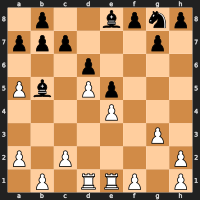

p 49 41


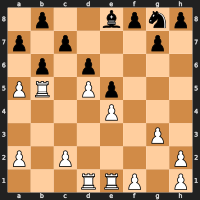

P 10 26


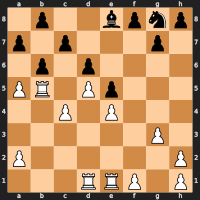

n 62 52


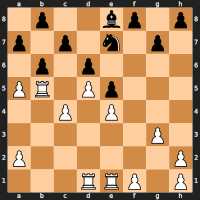

R 33 9


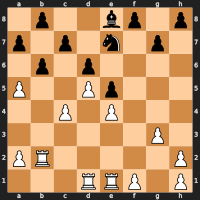

Default values initialized for cropping and rotation.

0: 640x640 2 black-bishops, 1 black-knight, 9 black-pawns, 1 black-rook, 1 white-bishop, 7 white-pawns, 1 white-queen, 2 white-rooks, 6.0ms
Speed: 1.6ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


/tmp/ipykernel_11395/4122921701.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))



0: 640x640 2 black-bishops, 1 black-knight, 8 black-pawns, 1 black-rook, 1 white-bishop, 7 white-pawns, 1 white-queen, 2 white-rooks, 11.9ms
Speed: 1.7ms preprocess, 11.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-knight, 7 black-pawns, 1 black-rook, 1 white-bishop, 7 white-pawns, 1 white-queen, 2 white-rooks, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 1 black-knight, 8 black-pawns, 1 black-rook, 1 white-bishop, 7 white-pawns, 2 white-queens, 2 white-rooks, 17.0ms
Speed: 2.3ms preprocess, 17.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 black-bishop, 1 black-king, 1 black-knight, 7 black-pawns, 1 black-rook, 1 white-bishop, 7 white-pawns, 1 white-queen, 2 white-rooks, 11.7ms
Speed: 1.7ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bl

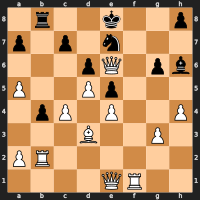

k 60 59


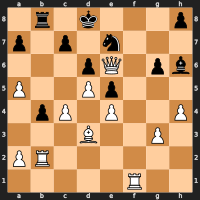

Q 44 4


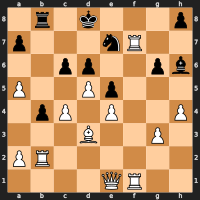

p 42 35


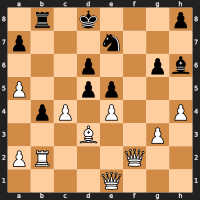

Q 13 48


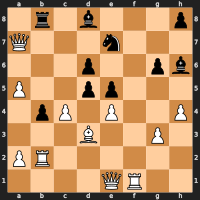

r 57 58


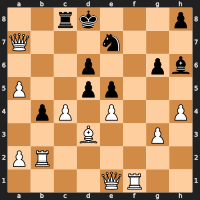

R 9 25


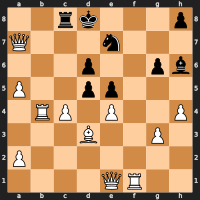

n 52 42


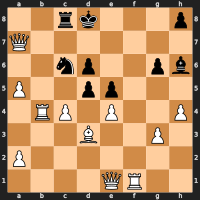

Q 48 41


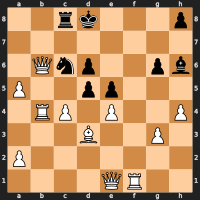

Default values initialized for cropping and rotation.

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 8 black-pawns, 1 black-queen, 1 black-rook, 1 white-bishop, 1 white-king, 2 white-knights, 8 white-pawns, 2 white-rooks, 15.4ms
Speed: 3.3ms preprocess, 15.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


/tmp/ipykernel_11395/4122921701.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))



0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 7 black-pawns, 1 black-queen, 1 black-rook, 2 white-bishops, 1 white-king, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 17.2ms
Speed: 3.1ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 7 black-pawns, 1 black-queen, 1 black-rook, 2 white-bishops, 2 white-kings, 2 white-knights, 8 white-pawns, 1 white-queen, 2 white-rooks, 5.1ms
Speed: 2.6ms preprocess, 5.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
q 59 31


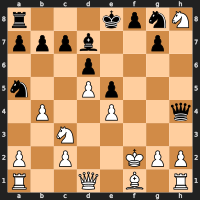

P 14 22


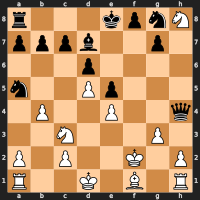

Default values initialized for cropping and rotation.

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 9 black-pawns, 1 black-queen, 1 black-rook, 1 white-king, 2 white-knights, 9 white-pawns, 1 white-rook, 5.7ms
Speed: 5.0ms preprocess, 5.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


/tmp/ipykernel_11395/4122921701.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))



0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 7 black-pawns, 1 black-queen, 1 black-rook, 1 white-king, 2 white-knights, 8 white-pawns, 2 white-rooks, 4.8ms
Speed: 4.6ms preprocess, 4.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 2 black-knights, 8 black-pawns, 1 black-queen, 1 black-rook, 1 white-bishop, 1 white-king, 2 white-knights, 9 white-pawns, 1 white-queen, 1 white-rook, 13.8ms
Speed: 4.9ms preprocess, 13.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
q 59 31


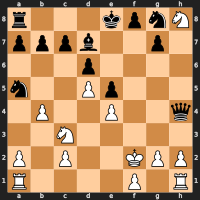

P 14 22


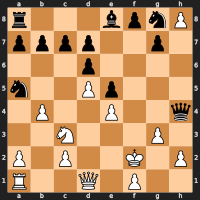

Default values initialized for cropping and rotation.

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 10 black-pawns, 1 black-queen, 1 black-rook, 3 white-bishops, 3 white-knights, 9 white-pawns, 1 white-queen, 2 white-rooks, 5.7ms
Speed: 1.6ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


/tmp/ipykernel_11395/4122921701.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))



0: 640x640 1 black-bishop, 1 black-king, 2 black-knights, 10 black-pawns, 1 black-queen, 1 black-rook, 2 white-bishops, 3 white-knights, 9 white-pawns, 2 white-queens, 2 white-rooks, 37.2ms
Speed: 29.1ms preprocess, 37.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 10 black-pawns, 1 black-queen, 1 black-rook, 3 white-bishops, 3 white-knights, 8 white-pawns, 2 white-queens, 2 white-rooks, 8.2ms
Speed: 1.7ms preprocess, 8.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 10 black-pawns, 1 black-queen, 1 black-rook, 3 white-bishops, 3 white-knights, 9 white-pawns, 2 white-queens, 2 white-rooks, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 9 black-pawns, 1 black-queen, 1 black-rook, 3 white-bishops, 2 white-knights,

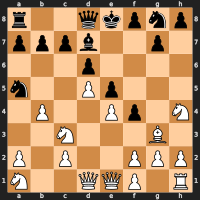

N 31 46


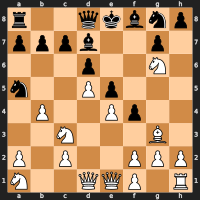

p 29 22


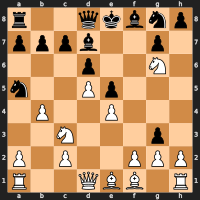

N 46 63


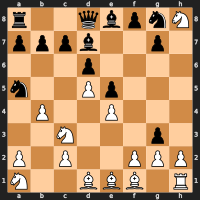

Default values initialized for cropping and rotation.


/tmp/ipykernel_11395/4122921701.py:63: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  point = int(np.round(point[0])), int(np.round(point[1]))



0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 10 black-pawns, 2 black-queens, 1 black-rook, 1 white-bishop, 10 white-pawns, 2 white-rooks, 11.5ms
Speed: 2.9ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 9 black-pawns, 2 black-queens, 1 black-rook, 1 white-bishop, 8 white-pawns, 1 white-rook, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 10 black-pawns, 2 black-queens, 1 black-rook, 1 white-bishop, 1 white-king, 1 white-knight, 9 white-pawns, 2 white-rooks, 5.3ms
Speed: 1.8ms preprocess, 5.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 black-bishops, 1 black-king, 2 black-knights, 10 black-pawns, 1 black-queen, 1 black-rook, 1 white-bishop, 1 white-king, 2 white-knights, 9 white-pawns, 2 white-rooks, 14.2ms
Speed: 2.3ms prepr

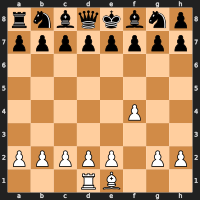

p 51 35


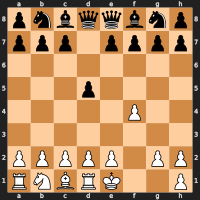

P 7 5


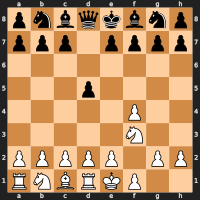

N 1 58


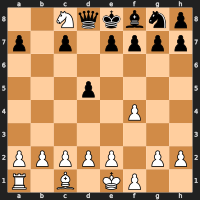

N 58 21


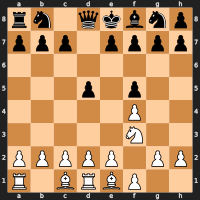

n 57 42


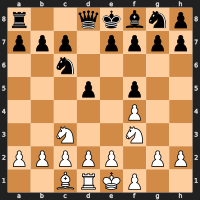

p 52 44


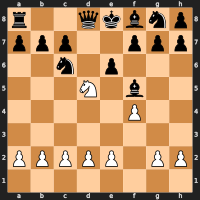

N 35 20


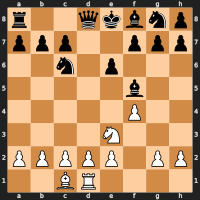

N 21 31


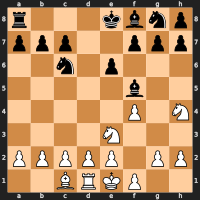

n 62 47


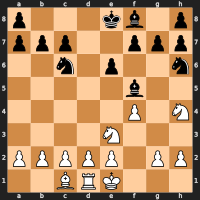

N 31 37


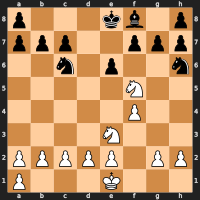

n 47 37


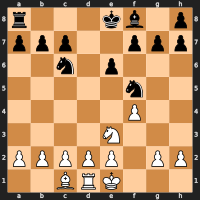

N 20 37


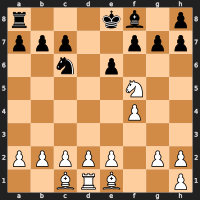

p 44 37


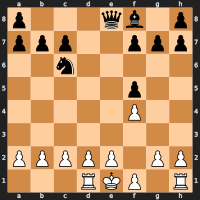

n 42 27


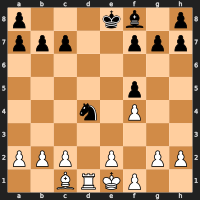

P 5 0


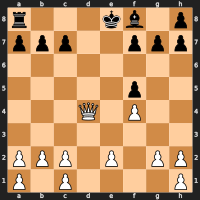

P 0 5


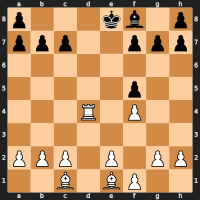

p 56 59


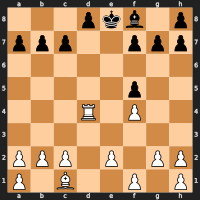

P 5 0


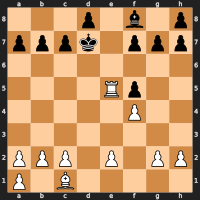

P 0 5


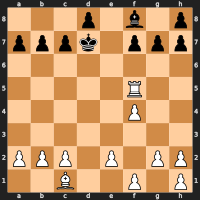

P 7 0


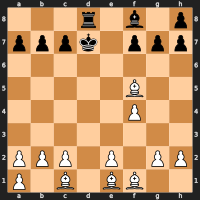

P 0 7


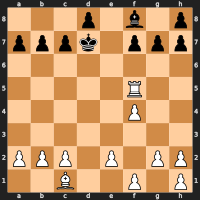

k 51 42


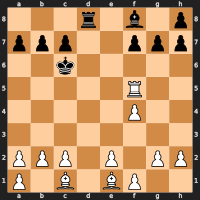

B 2 53


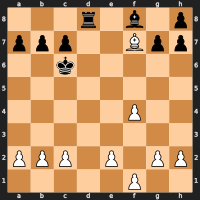

p 54 38


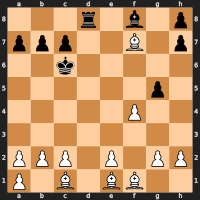

P 29 38


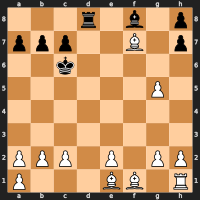

B 4 2


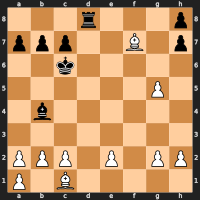

B 2 53


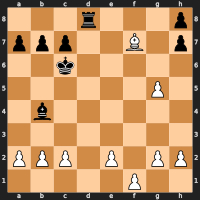

P 10 18


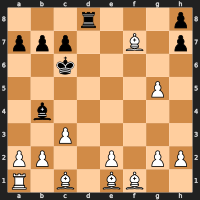

In [12]:
csv_output=[]
for dirname, _, filenames in os.walk(dataset_root):
    for filename in filenames:
      if filename.endswith(".mp4"):
        file_path = os.path.join(dirname, filename)
        bbox_of_each_video = process_video(file_path,frame_per_second=30,chess_model_path=chess_model,hand_model_path=hand_model,Debug=False)
        csv_output.append(post_process_pipeline(filename,bbox_of_each_video))

# bonus_file_flag = False
# for (row_id, output) in csv_output:
#     if row_id == "(Bonus)Long_video_student.mp4":
#         bonus_file_flag = True
#         break

# if not bonus_file_flag:
#     csv_output.append(["(Bonus)Long_video_student.mp4", "1. d4 Nf6 2. c4 e6 3. Nf3 d5 4. Nc3 Bb4 5. e3 O-O 6. Bd3 c5 7. O-O dxc4 8. Bxc4 cxd4 9. exd4 Nc6 10. a3 Be7"])

## Export to csv

In [13]:
export_csv_result(csv_output)